In [ ]:
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Removing lung masks from dataset

In [ ]:
# Clean dataset by removing lung mask folders - we only need raw X-ray images for classification
def delete_folders(base_dir, folders_to_delete):
    for root, dirs, files in os.walk(base_dir):
        for dir_name in dirs:
            if dir_name in folders_to_delete:
                folder_path = os.path.join(root, dir_name)
                print(f"Deleting folder: {folder_path}")
                shutil.rmtree(folder_path)

# Dataset directory paths for train, test, and validation sets
directories = [
    'COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train',
    'COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test',
    'COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val'
]

folders_to_delete = ['lung masks']

# Remove lung masks from all directories
for directory in directories:
    delete_folders(directory, folders_to_delete)

Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/lung masks
Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/lung masks
Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train/Normal/lung masks
Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/lung masks
Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/lung masks
Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test/Normal/lung masks
Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks
Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/lung masks
Deleting folder: COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val/Normal/lung masks


### Loading dataset

In [ ]:
# Load training data - shuffled for better training
train_data = tf.keras.utils.image_dataset_from_directory(
    'COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train',
    image_size=(224,224),
    batch_size=32,
    validation_split=False
)

# Load validation data - no shuffling for consistent evaluation
validation_data = tf.keras.utils.image_dataset_from_directory(
    'COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val',
    shuffle=False,
    image_size=(224,224),
    batch_size=32,
    validation_split=False
)

# Load test data - final model evaluation
test_data = tf.keras.utils.image_dataset_from_directory(
    'COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test',
    shuffle=False,
    image_size=(224,224),
    batch_size=32,
    validation_split=False
)

Found 21715 files belonging to 3 classes.


2024-07-08 19:53:34.495162: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-08 19:53:34.495186: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-08 19:53:34.495193: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-08 19:53:34.495210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-08 19:53:34.495223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5417 files belonging to 3 classes.
Found 6788 files belonging to 3 classes.


In [4]:
# Get class names - shows the 3 categories for classification
data_cat = train_data.class_names
print(data_cat)

['COVID-19', 'Non-COVID', 'Normal']


2024-07-08 21:03:21.610971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


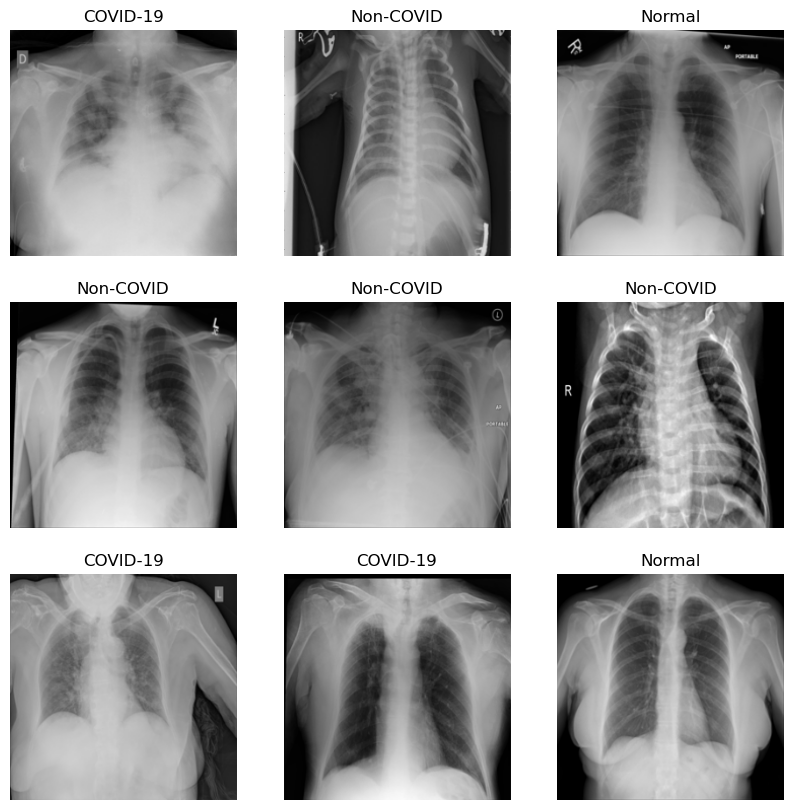

In [ ]:
# Display sample training images to visualize dataset
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

### Model construction

In [ ]:
# Build CNN architecture for 3-class chest X-ray classification
model = Sequential()

# Input layer - accepts 224x224 RGB images
model.add(InputLayer((224, 224, 3)))

# Normalization layer - scale pixel values from [0,255] to [0,1]
model.add(Rescaling(1./255))

# First convolutional block - extract low-level features
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPooling2D())

# Second convolutional block - extract higher-level features
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D())

# Flatten feature maps for dense layers
model.add(Flatten())

# Dense layers - learn complex patterns for classification
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer - 3 classes with softmax for probability distribution
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    47,776,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,956,003 (182.94 MB)

 Trainable params: 47,956,003 (182.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model with Adam optimizer and sparse categorical crossentropy
model.compile(
    loss = "sparse_categorical_crossentropy", 
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics =["accuracy"])

In [ ]:
# Early stopping to prevent overfitting - stops if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Model Training

Now we'll train the model using the training and validation datasets. The training process will:

**Training Configuration:**
- **Epochs**: Maximum of 100 epochs (will stop early if validation loss doesn't improve)
- **Batch Size**: 32 images per batch (defined in dataset loading)
- **Validation**: Model performance evaluated on validation set after each epoch
- **Early Stopping**: Training stops if validation loss doesn't improve for 5 consecutive epochs

**What happens during training:**
- Model learns to distinguish between COVID-19, Non-COVID, and Normal chest X-rays
- Weights are adjusted to minimize classification errors
- Progress is monitored through training and validation metrics
- Best model weights are saved automatically

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100


2024-07-08 19:53:40.114018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


679/679 ━━━━━━━━━━━━━━━━━━━━ 106s 154ms/step - accuracy: 0.5843 - loss: 0.8837 - val_accuracy: 0.7689 - val_loss: 0.5800
Epoch 2/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 107s 157ms/step - accuracy: 0.7708 - loss: 0.5810 - val_accuracy: 0.7851 - val_loss: 0.5600
Epoch 3/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 106s 156ms/step - accuracy: 0.8009 - loss: 0.5030 - val_accuracy: 0.8255 - val_loss: 0.4539
Epoch 4/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 118s 174ms/step - accuracy: 0.8275 - loss: 0.4365 - val_accuracy: 0.8366 - val_loss: 0.4253
Epoch 5/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 124s 182ms/step - accuracy: 0.8492 - loss: 0.3838 - val_accuracy: 0.8425 - val_loss: 0.4072
Epoch 6/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 120s 177ms/step - accuracy: 0.8698 - loss: 0.3319 - val_accuracy: 0.8431 - val_loss: 0.4132
Epoch 7/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 119s 176ms/step - accuracy: 0.8852 - loss: 0.2859 - val_accuracy: 0.8577 - val_loss: 0.3977
Epoch 8/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 121s 178ms/step - accuracy: 0.9078 - los

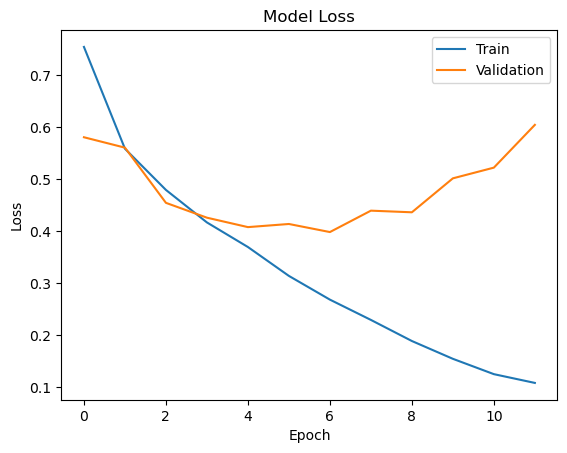

In [ ]:
# Plot training and validation loss to monitor overfitting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

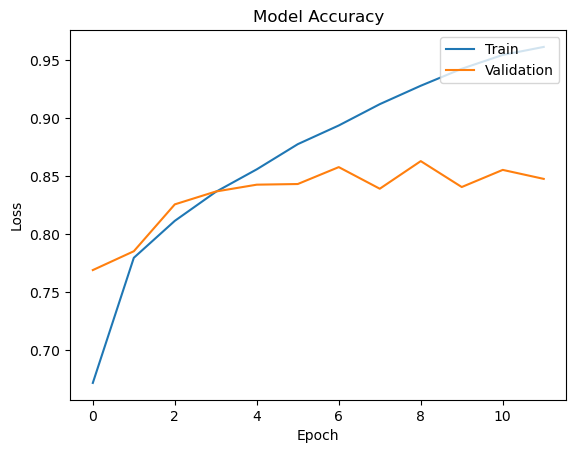

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

From the graphs we can observe that after epoch 7 the model starts overfitting, so using the early stopping created, this is chosen as the final model

### Model evaluation

In [ ]:
# Evaluate model performance on unseen test dataset
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8805 - loss: 0.3581
Test Accuracy: 0.8719799518585205, Test Loss: 0.3642883598804474


### Results Analysis

**Final Model Performance:**
- **Test Accuracy: 87.2%** - Strong performance for medical image classification
- **Test Loss: 0.364** - Low loss indicates confident predictions

**Performance Interpretation:**
- The model correctly identifies COVID-19, Non-COVID, and Normal chest X-rays in 87.2% of cases
- This accuracy level is suitable for a screening tool, though clinical validation would be needed
- The relatively low loss suggests the model makes confident predictions rather than uncertain guesses


### Saving the model

In [ ]:
# Save the trained model for deployment
model.save("covid_xray_model.keras")